In [1]:
%load_ext autoreload
%autoreload 2
import random
import numpy as np
import torch
import matplotlib.pyplot as plt


In [61]:
import random
import numpy as np
import torch
import matplotlib.pyplot as plt

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

from mixture_lower import Mixture
from guided_models import Diffusion
from chernoff_gpt import ChernoffGuidance

results = {}

# Diffusion parameters
n = T = 20
t_vals = np.arange(1, n+1)
c, delta = 4, 0.02
inner = delta * (1 + c * np.log(n) / n)**t_vals
alpha_t = 1 - (c * np.log(n) / n) * np.minimum(inner, 1)
alpha_t[0] = 1 - delta
d = 2

# Mixture setup
mu_0 = np.array([[5, 0], [-5, 0]])
var_0 = np.eye(d)
pi_0 = np.array([0.95, 0.05])
pi_0 /= np.sum(pi_0)
dist0 = Mixture(mu_0, var_0, pi_0)
diffusion_unguided = Diffusion(dist0, alpha_t, S=50_000)
# X_unguided = diffusion_unguided.calc_samples()
unguided_num_steps = T*50_000

X = diffusion_unguided.calc_samples()



Reverse Diffusion Progress: 100%|██████████| 19/19 [00:21<00:00,  1.13s/it]


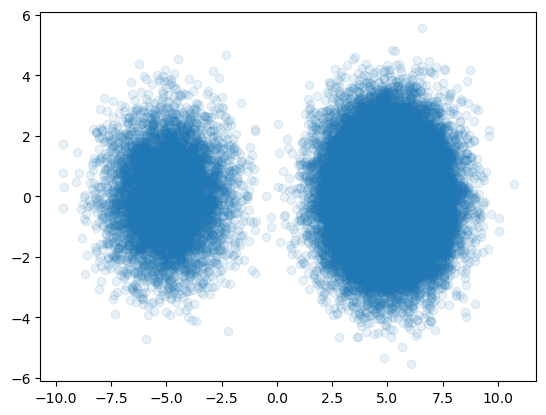

In [62]:
plt.scatter(X[:, -1, 0], X[:, -1, 1], alpha=0.1)

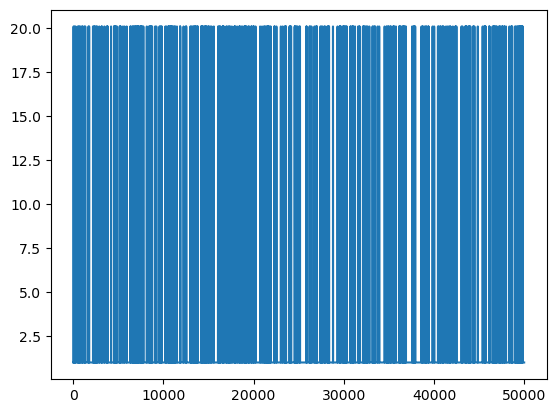

In [63]:
B = 3
def reward_func_hard(x):
    """
    Hard step function for 2D input.
    Returns B when x[..., 0] < -7, and 0 otherwise.
    """
    x0 = np.asarray(x)[..., 0]
    return np.where(x0 < -7, B, 0)

expr = np.exp(reward_func_hard(X[:, -1, :]))
plt.plot(expr)

In [64]:
from value_estimator import ValueEstimate
val_ensemble = ValueEstimate(X, expr, [128, 500, 500])
val_ensemble.train()


Building ValueEstimate...
[Epoch 01] avg MSE: 2.6122
[Epoch 02] avg MSE: 2.4746
[Epoch 03] avg MSE: 2.2995
[Epoch 04] avg MSE: 2.2180
[Epoch 05] avg MSE: 2.1955
[Epoch 06] avg MSE: 2.1838
[Epoch 07] avg MSE: 2.1788
[Epoch 08] avg MSE: 2.1651
[Epoch 09] avg MSE: 2.1619
[Epoch 10] avg MSE: 2.1555
[Epoch 11] avg MSE: 2.1484
[Epoch 12] avg MSE: 2.1458
[Epoch 13] avg MSE: 2.1421
[Epoch 14] avg MSE: 2.1386
[Epoch 15] avg MSE: 2.1321
[Epoch 16] avg MSE: 2.1300
[Epoch 17] avg MSE: 2.1272
[Epoch 18] avg MSE: 2.1230
[Epoch 19] avg MSE: 2.1188
[Epoch 20] avg MSE: 2.1143


2.1142564554439782

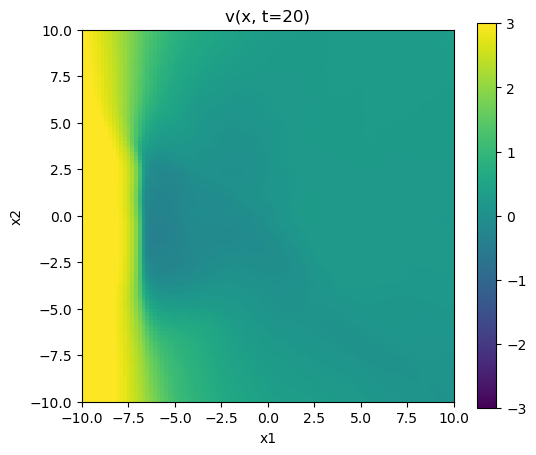

In [142]:
from matplotlib import animation

# Create a grid of x values
x1 = np.linspace(-10, 10, 100)
x2 = np.linspace(-10, 10, 100)
xx1, xx2 = np.meshgrid(x1, x2)
grid_x = np.stack([xx1.ravel(), xx2.ravel()], axis=1)

fig, ax = plt.subplots(figsize=(6, 5))
cax = ax.imshow(np.zeros_like(xx1), extent=[-10, 10, -10, 10], origin='lower', vmin=-B, vmax=B)
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('v(x, t) over time')
cb = fig.colorbar(cax)

t_vals = list(range(1, n + 1))

def animate(t_idx):
    t = t_vals[t_idx]
    t_arr = np.full((grid_x.shape[0],), t)
    v = val_ensemble.predict_under_log(grid_x, t_arr)
    v = np.squeeze(v)
    v_img = v.reshape(xx1.shape)
    cax.set_data(v_img)
    ax.set_title(f'v(x, t={t})')
    return [cax]

ani = animation.FuncAnimation(fig, animate, frames=len(t_vals), interval=100, blit=True)
ani.save('v_under_log_over_time_differentiable.gif', writer='pillow', fps=2)
plt.show()

In [ ]:
chernoff_guided = ChernoffGuidance(dist0, alpha_t, lambda t, x: (np.log(np.clip(val_ensemble.predict(x, t), np.e**(-B), np.e**B))), iters = 1000, fix_lambda=True, lambda_value = 8)

In [164]:
X_train = chernoff_guided.train_baselines_and_sample()

Chernoff backward:   0%|          | 0/19 [00:00<?, ?it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=18:   2%|▏         | 23/1000 [00:00<00:29, 33.62it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=18:  78%|███████▊  | 783/1000 [00:29<00:06, 34.37it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=18:  81%|████████  | 807/1000 [00:30<00:05, 34.54it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=18:  90%|█████████ | 903/1000 [00:33<00:02, 34.67it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=18:  91%|█████████ | 911/1000 [00:33<00:02, 34.71it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=18: 100%|██████████| 1000/1000 [00:36<00:00, 27.77it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff b_(t+1) @ t=17:   1%|          | 8/1000 [00:00<00:28, 34.88it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=17:  11%|█         | 108/1000 [00:03<00:26, 34.05it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=17:  30%|██▉       | 295/1000 [00:09<00:20, 33.58it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=17:  85%|████████▌ | 852/1000 [00:29<00:04, 34.09it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=17: 100%|██████████| 1000/1000 [00:33<00:00, 29.74it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 10000, 2)


Chernoff backward:  11%|█         | 2/19 [01:19<11:11, 39.52s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=16:  18%|█▊        | 176/1000 [00:05<00:24, 34.16it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=16:  36%|███▋      | 365/1000 [00:11<00:18, 34.51it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=16:  41%|████      | 409/1000 [00:13<00:17, 34.22it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=16:  42%|████▎     | 425/1000 [00:13<00:16, 34.61it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=16:  53%|█████▎    | 529/1000 [00:16<00:13, 34.58it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=16:  60%|█████▉    | 597/1000 [00:18<00:11, 34.55it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=16:  64%|██████▎   | 637/1000 [00:19<00:10, 34.57it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=16: 100%|██████████| 1000/1000 [00:31<00:00, 32.03it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  16%|█▌        | 3/19 [01:57<10:20, 38.78s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=15:  88%|████████▊ | 881/1000 [00:34<00:04, 24.36it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=15: 100%|██████████| 1000/1000 [00:38<00:00, 25.67it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  21%|██        | 4/19 [02:41<10:13, 40.92s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=14:   4%|▍         | 38/1000 [00:01<00:31, 30.16it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=14:  22%|██▏       | 219/1000 [00:08<00:29, 26.19it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=14:  29%|██▊       | 286/1000 [00:10<00:23, 29.93it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=14:  73%|███████▎  | 729/1000 [00:26<00:08, 30.51it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=14: 100%|██████████| 1000/1000 [00:36<00:00, 27.32it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 10000, 2)


Chernoff backward:  26%|██▋       | 5/19 [03:23<09:38, 41.29s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=13:  22%|██▏       | 223/1000 [00:07<00:25, 29.99it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=13:  26%|██▌       | 256/1000 [00:08<00:26, 28.26it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=13:  51%|█████     | 509/1000 [00:18<00:17, 28.38it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=13:  52%|█████▏    | 523/1000 [00:19<00:16, 29.53it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=13:  63%|██████▎   | 627/1000 [00:22<00:12, 29.90it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=13:  63%|██████▎   | 634/1000 [00:23<00:12, 29.97it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=13: 100%|██████████| 1000/1000 [00:36<00:00, 27.39it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 10000, 2)


Chernoff backward:  32%|███▏      | 6/19 [04:04<08:57, 41.31s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=12:  11%|█         | 106/1000 [00:03<00:30, 29.63it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=12:  27%|██▋       | 267/1000 [00:09<00:24, 29.41it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=12:  94%|█████████▍| 940/1000 [00:35<00:03, 15.45it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=12: 100%|██████████| 1000/1000 [00:37<00:00, 26.32it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 10000, 2)


Chernoff backward:  37%|███▋      | 7/19 [04:47<08:22, 41.84s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=11:  49%|████▉     | 491/1000 [00:20<00:17, 28.68it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=11:  88%|████████▊ | 875/1000 [00:34<00:04, 29.84it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=11:  91%|█████████ | 906/1000 [00:35<00:03, 29.80it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=11: 100%|██████████| 1000/1000 [00:39<00:00, 25.58it/s]


Xprop shape: (1, 10000, 2)


Chernoff backward:  42%|████▏     | 8/19 [05:31<07:47, 42.50s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=10:  58%|█████▊    | 582/1000 [00:22<00:13, 29.90it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=10:  64%|██████▎   | 637/1000 [00:24<00:12, 28.50it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=10:  91%|█████████▏| 913/1000 [00:35<00:03, 27.86it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=10: 100%|██████████| 1000/1000 [00:38<00:00, 25.93it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 10000, 2)


Chernoff backward:  47%|████▋     | 9/19 [06:15<07:08, 42.86s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=9: 100%|██████████| 1000/1000 [00:39<00:00, 25.43it/s]


Xprop shape: (1, 10000, 2)


Chernoff backward:  53%|█████▎    | 10/19 [07:00<06:31, 43.45s/it]

Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=8:  45%|████▍     | 447/1000 [00:20<00:18, 29.55it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=8:  66%|██████▌   | 659/1000 [00:29<00:15, 22.13it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=8:  84%|████████▍ | 844/1000 [00:36<00:05, 29.68it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=8: 100%|██████████| 1000/1000 [00:41<00:00, 24.00it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  58%|█████▊    | 11/19 [07:46<05:55, 44.40s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=7:  40%|████      | 402/1000 [00:16<00:34, 17.50it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=7:  72%|███████▏  | 721/1000 [00:28<00:16, 16.75it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=7:  96%|█████████▌| 957/1000 [00:39<00:01, 29.32it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=7: 100%|██████████| 1000/1000 [00:41<00:00, 24.28it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  63%|██████▎   | 12/19 [08:32<05:14, 44.92s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=6:  13%|█▎        | 126/1000 [00:04<00:30, 28.67it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=6:  54%|█████▍    | 538/1000 [00:20<00:17, 26.70it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=6:  68%|██████▊   | 684/1000 [00:27<00:10, 29.92it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=6:  69%|██████▉   | 691/1000 [00:27<00:10, 30.17it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=6:  75%|███████▍  | 749/1000 [00:29<00:08, 29.35it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=6:  88%|████████▊ | 883/1000 [00:34<00:04, 23.69it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=6: 100%|██████████| 1000/1000 [00:39<00:00, 25.32it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 10000, 2)


Chernoff backward:  68%|██████▊   | 13/19 [09:17<04:29, 44.84s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=5:  18%|█▊        | 176/1000 [00:06<00:30, 27.18it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=5:  37%|███▋      | 373/1000 [00:14<00:21, 29.13it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=5:  45%|████▍     | 449/1000 [00:16<00:20, 27.31it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=5:  66%|██████▌   | 660/1000 [00:24<00:12, 28.07it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=5:  84%|████████▍ | 840/1000 [00:30<00:05, 28.16it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=5:  91%|█████████ | 907/1000 [00:32<00:03, 29.40it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=5:  96%|█████████▋| 965/1000 [00:35<00:01, 29.74it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=5: 100%|██████████| 1000/1000 [00:36<00:00, 27.59it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  74%|███████▎  | 14/19 [09:58<03:39, 43.82s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=4:  67%|██████▋   | 668/1000 [00:23<00:11, 29.65it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=4:  85%|████████▌ | 853/1000 [00:30<00:05, 28.29it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=4: 100%|██████████| 1000/1000 [00:35<00:00, 27.92it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  79%|███████▉  | 15/19 [10:39<02:51, 42.93s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=3:  27%|██▋       | 274/1000 [00:09<00:26, 27.53it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=3:  60%|██████    | 601/1000 [00:21<00:14, 28.47it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=3:  86%|████████▌ | 860/1000 [00:31<00:04, 29.68it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=3: 100%|██████████| 1000/1000 [00:36<00:00, 27.74it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  84%|████████▍ | 16/19 [11:20<02:07, 42.38s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=2:  20%|██        | 203/1000 [00:07<00:28, 28.39it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=2:  93%|█████████▎| 930/1000 [00:35<00:02, 28.15it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=2:  99%|█████████▉| 992/1000 [00:37<00:00, 29.26it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=2: 100%|██████████| 1000/1000 [00:37<00:00, 26.39it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  89%|████████▉ | 17/19 [12:03<01:25, 42.53s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=1:   6%|▋         | 64/1000 [00:02<00:32, 28.86it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=1:  14%|█▍        | 144/1000 [00:05<00:29, 28.61it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)



Chernoff b_(t+1) @ t=1:  68%|██████▊   | 683/1000 [00:24<00:10, 30.35it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=1: 100%|██████████| 1000/1000 [00:35<00:00, 27.88it/s]


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 10000, 2)


Chernoff backward:  95%|█████████▍| 18/19 [12:44<00:42, 42.03s/it]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=0:  53%|█████▎    | 529/1000 [00:19<00:16, 28.38it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Chernoff b_(t+1) @ t=0: 100%|██████████| 1000/1000 [00:36<00:00, 27.59it/s]

Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)
Xprop shape: (1, 1024, 2)


Xprop shape: (1, 10000, 2)


Chernoff backward: 100%|██████████| 19/19 [13:26<00:00, 42.42s/it]


In [151]:
X_chern = chernoff_guided.calc_samples(5000)

Chernoff inference: 100%|██████████| 19/19 [00:45<00:00,  2.40s/it]


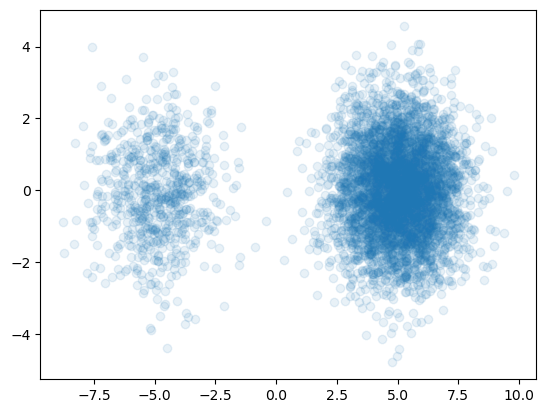

In [ ]:
plt.scatter(X_train[:, -1, 0], X_train[:, -1, 1], alpha=0.1)
plt.scatter(X_chern[:, -1, 0], X_chern[:,-1, 1], alpha=0.1)

In [163]:
X_guided = chernoff_guided.calc_samples(5000)

Chernoff inference:  11%|█         | 2/19 [00:06<00:53,  3.12s/it]

Unexpected exception formatting exception. Falling back to standard exception



Traceback (most recent call last):
  File "/Users/sunilmadhow/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/zk/bk5jkrk11398bfvxps9gbhw00000gn/T/ipykernel_37167/4017359168.py", line 1, in <module>
    X_guided = chernoff_guided.calc_samples(5000)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sunilmadhow/Desktop/Desktop/guidance/chernoff_gpt.py", line 418, in calc_samples
    X[:, t, :] = self.single_step_guide(t, Ytp1, batch_size=batch_size)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sunilmadhow/Desktop/Desktop/guidance/chernoff_gpt.py", line 310, in single_step_guide
    Xprop = super().single_step_iid_copies(t, Ytp1[active], size=batch_size)  # (B, Ka, d)
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/sunilmadhow/Desktop/Desktop/guidance/guided_models.py

In [153]:
chernoff_guided.taus

array([0.74879277, 0.77201402, 0.80100858, 0.82767522, 0.85874081,
       0.89242393, 0.92316186, 0.96394086, 0.9552049 , 1.37407112,
       1.25563955, 0.9435966 , 1.92864895, 0.87159151, 0.83150882,
       0.80308825, 0.75023711, 0.7323308 , 0.73611814])

In [154]:
bl = chernoff_guided.baseline

In [155]:
def visualize_baseline_2d(baseline, t_scalar, grid_size=100, value_range=(-3, 3)):
        """
        Visualizes log u_{t+1}(y_{t+1}) over a 2D grid for d=2.
        Args:
            baseline: LogUBaselineNet instance
            t_scalar: time index (int)
            grid_size: number of points per axis
            value_range: tuple (min, max) for each axis
        """
        import matplotlib.pyplot as plt

        if baseline.d != 2:
            raise ValueError("Visualization only supported for d=2.")

        x = np.linspace(value_range[0], value_range[1], grid_size)
        y = np.linspace(value_range[0], value_range[1], grid_size)
        xx, yy = np.meshgrid(x, y)
        grid = np.stack([xx.ravel(), yy.ravel()], axis=1)  # (grid_size^2, 2)

        with torch.no_grad():
            grid_tensor = torch.tensor(grid, dtype=torch.float32, device=baseline.device)
            logu = baseline(grid_tensor, t_scalar).cpu().numpy().reshape(grid_size, grid_size)

        plt.figure(figsize=(6, 5))
        plt.imshow(logu, extent=(value_range[0], value_range[1], value_range[0], value_range[1]),
                   origin='lower', aspect='auto', cmap='viridis')
        plt.colorbar(label='log u')
        plt.title(f"log u_{{t+1}}(y_{{t+1}}), t={t_scalar}")
        plt.xlabel("y1")
        plt.ylabel("y2")
        plt.show()

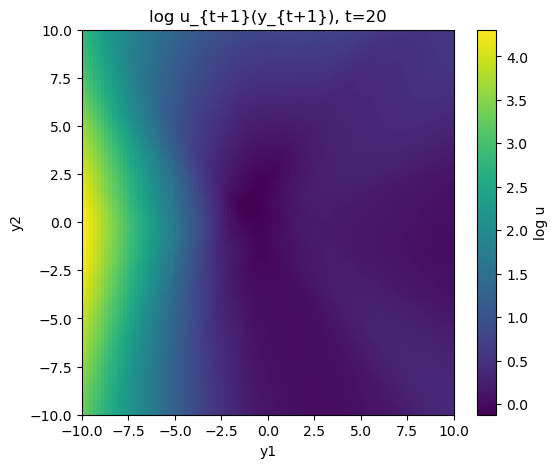

In [161]:
visualize_baseline_2d(bl, 20, grid_size=100, value_range=(-10, 10))

In [162]:
chernoff_guided.lambdas

array([8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8., 8.,
       8., 8.])